In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["font.family"] = "sans-serif"

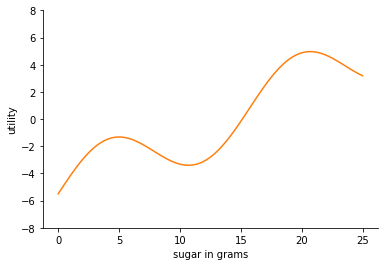

In [2]:
def f(x):
    return (np.sin(x / 2.5) * 6 + x) / 2.5 - 5.5


x_test = np.linspace(0, 25, 100).reshape(-1, 1)

plt.plot(x_test, f(x_test), c="C1", label="objective")

plt.ylim(-8, 8)
plt.xlabel("sugar in grams")
plt.ylabel("utility")
plt.show()

In [3]:
import torch
import gpytorch

import sys

sys.path.append("../")

from optimization.opt_utils import fit_model
from scipy.stats import norm

# the expected improvement policy

In [4]:
x_train = torch.tensor([[3], [12], [20], [4], [11]]).float()

comp_train = torch.tensor(
    [
        [0, 1],  # f(3) > f(12)
        [2, 0],  # f(3) < f(20)
        [2, 1],  # f(12) < f(20)
        [2, 3],
        [2, 4],
    ]
).long()

model = fit_model(
    x_train,
    comp_train,
    covar_module=gpytorch.kernels.RBFKernel(
        lengthscale_constraint=gpytorch.constraints.GreaterThan(2.5)
    ),
)

In [5]:
with torch.no_grad():
    output = model(torch.tensor(x_test))
    lower, upper = output.confidence_region()


star_ind = np.argmax(output.mean.numpy())
x_star = x_test[star_ind]
y_star = output.mean.numpy()[star_ind]
x_star, y_star

/Users/quannguyen/anaconda3/envs/preference_botorch/lib/python3.9/site-packages/botorch/models/pairwise_gp.py:283: RuntimeWarning: X is not a p.d. matrix; Added jitter of 1.00e-05 to the diagonal
  warnings.warn(


(array([19.94949495]), 0.88804585)

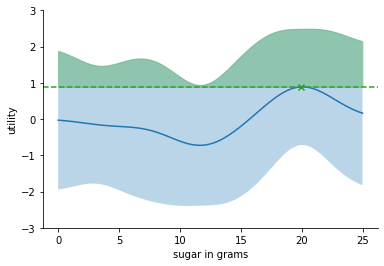

In [6]:
with torch.no_grad():
    output = model(torch.tensor(x_test))
    lower, upper = output.confidence_region()

plt.plot(x_test, output.mean, label="mean")
plt.fill_between(x_test.flatten(), lower, upper, alpha=0.3, label="CI")

star_ind = np.argmax(output.mean.numpy())
x_star = x_test[star_ind]
y_star = output.mean.numpy()[star_ind]

plt.scatter(x_star, y_star, c="C2", marker="x")
plt.axhline(y_star, c="C2", linestyle="--")

plt.fill_between(x_test.flatten(), upper, y_star, color="C2", alpha=0.3)

plt.xlabel("sugar in grams")
plt.ylabel("utility")
plt.ylim(-3, 3)

plt.show()

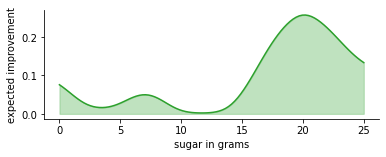

In [7]:
mu = output.mean.detach().numpy()
sigma = output.covariance_matrix.diag().detach().numpy()

improvements = mu - y_star
Z = improvements / sigma
ei = improvements * norm.cdf(Z) + sigma * norm.pdf(Z)

plt.figure(figsize=(6, 2))

plt.plot(x_test, ei, c="C2")
plt.fill_between(x_test.flatten(), ei, 0, color="C2", alpha=0.3)

plt.xlabel("sugar in grams")
plt.ylabel("expected improvement")

plt.show()

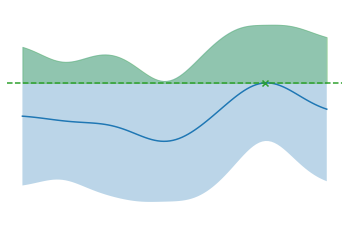

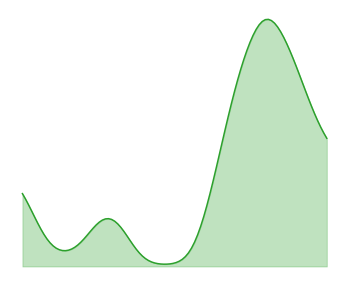

In [20]:
plt.plot(x_test, output.mean, label="mean")
plt.fill_between(x_test.flatten(), lower, upper, alpha=0.3, label="CI")

star_ind = np.argmax(output.mean.numpy())
x_star = x_test[star_ind]
y_star = output.mean.numpy()[star_ind]

plt.scatter(x_star, y_star, c="C2", marker="x")
plt.axhline(y_star, c="C2", linestyle="--")

plt.fill_between(x_test.flatten(), upper, y_star, color="C2", alpha=0.3)

plt.xticks([])
plt.yticks([])
plt.axis("off")
plt.ylim(-3, 3)

plt.show()

mu = output.mean.detach().numpy()
sigma = output.covariance_matrix.diag().detach().numpy()

improvements = mu - y_star
Z = improvements / sigma
ei = improvements * norm.cdf(Z) + sigma * norm.pdf(Z)

plt.figure(figsize=(6, 5))

plt.plot(x_test, ei, c="C2")
plt.fill_between(x_test.flatten(), ei, 0, color="C2", alpha=0.3)

plt.xticks([])
plt.yticks([])
plt.axis("off")
plt.show()

# the optimization loop

In [8]:
from optimization.experiments import single_experiment
from policies.incumbent import IncumbentExpectedImprovement

In [13]:
def visualize_belief_and_ei(model, x_train, comp_train, f):
    with torch.no_grad():
        output = model(torch.tensor(x_test))
        lower, upper = output.confidence_region()

    plt.plot(x_test, output.mean, label="mean")
    plt.fill_between(x_test.flatten(), lower, upper, alpha=0.3, label="CI")

    plt.plot(x_test, f(x_test) / 2.5, linestyle="--")

    plt.xlabel("sugar in grams")
    plt.ylabel("utility")
    plt.ylim(-3, 3)

    plt.show()

    print()

    mu = output.mean.detach().numpy()
    sigma = output.covariance_matrix.diag().detach().numpy()

    improvements = mu - y_star
    Z = improvements / sigma
    ei = improvements * norm.cdf(Z) + sigma * norm.pdf(Z)

    plt.figure(figsize=(6, 2))

    plt.plot(x_test, ei, c="C2")
    plt.fill_between(x_test.flatten(), ei, 0, color="C2", alpha=0.3)

    # plt.axvline(x_test[np.argmax(ei)], linestyle="--", c="C3")  # candidate
    # plt.axvline(x_test[torch.argmax(output.mean)], linestyle="--", c="C2")  # incumbent

    plt.xlabel("sugar in grams")
    plt.ylabel("expected improvement")

    plt.show()

    print()

    plt.figure(figsize=(6, 2))

    plt.plot(x_test, ei, c="C2")
    plt.fill_between(x_test.flatten(), ei, 0, color="C2", alpha=0.3)

    plt.axvline(x_test[np.argmax(ei)], linestyle="--", c="C3")  # candidate
    # plt.axvline(x_test[torch.argmax(output.mean)], linestyle="--", c="C2")  # incumbent

    plt.xlabel("sugar in grams")
    plt.ylabel("expected improvement")

    plt.show()

    plt.figure(figsize=(6, 2))

    plt.plot(x_test, ei, c="C2")
    plt.fill_between(x_test.flatten(), ei, 0, color="C2", alpha=0.3)

    plt.axvline(x_test[np.argmax(ei)], linestyle="--", c="C3")  # candidate
    plt.axvline(x_test[torch.argmax(output.mean)], linestyle="--", c="C2")  # incumbent

    plt.xlabel("sugar in grams")
    plt.ylabel("expected improvement")

    plt.show()

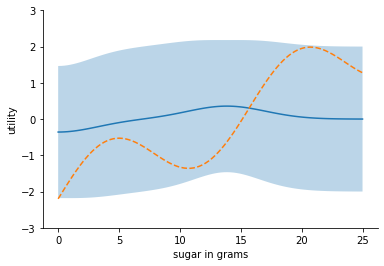

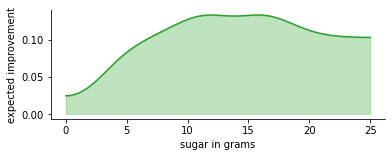

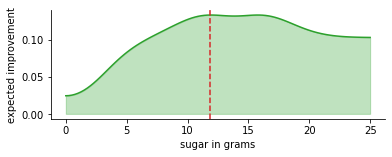

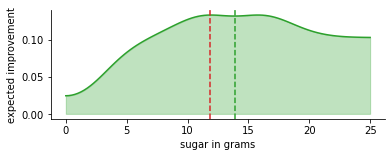

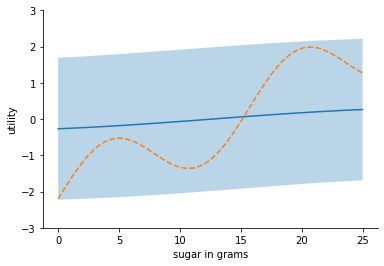

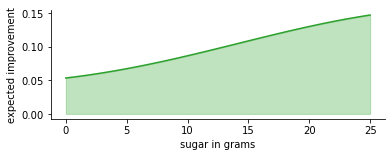

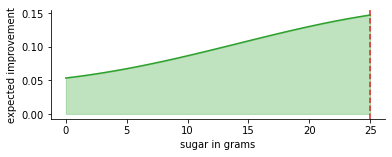

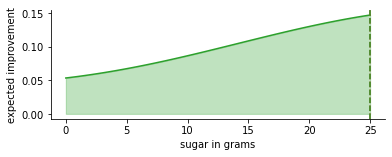

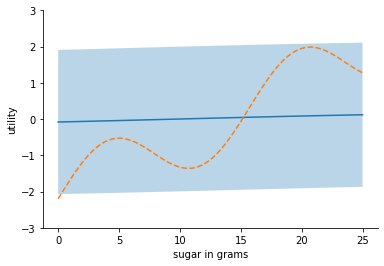

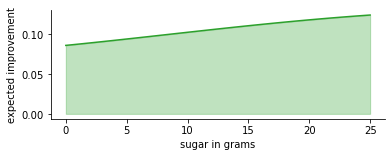

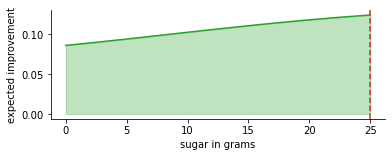

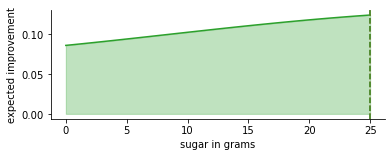

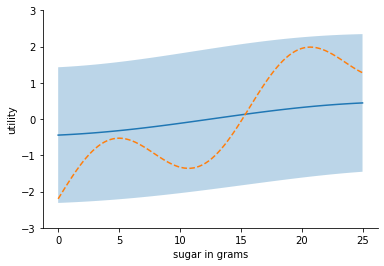

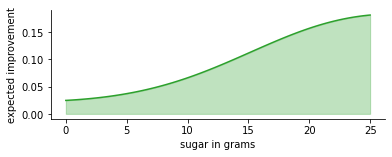

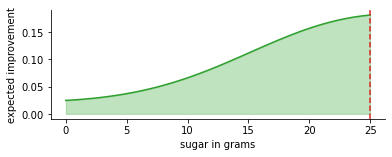

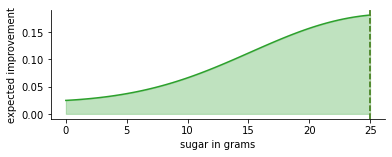

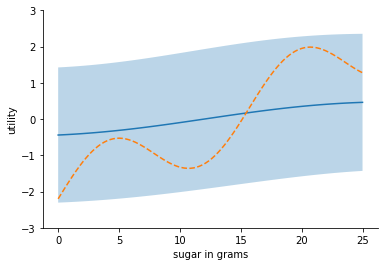

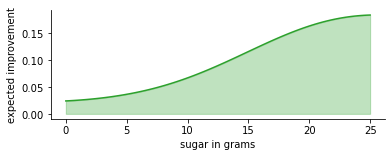

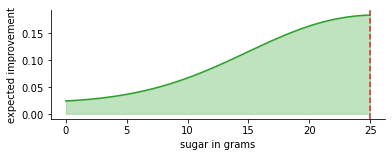

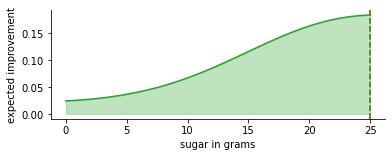

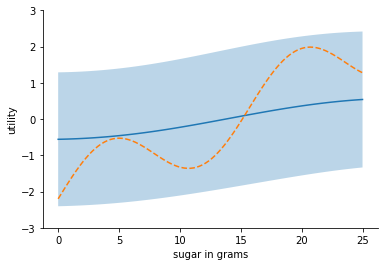

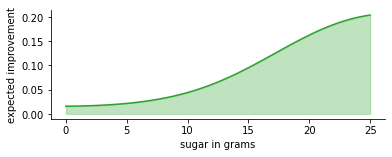

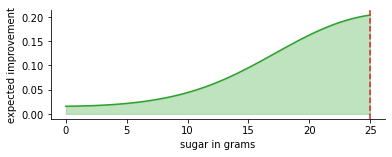

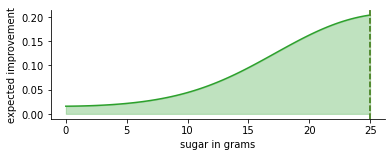

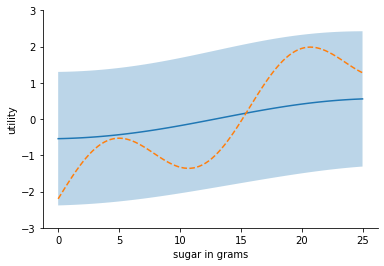

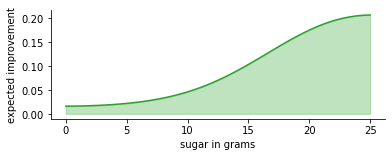

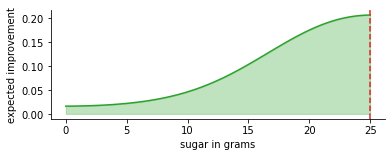

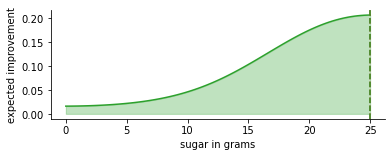

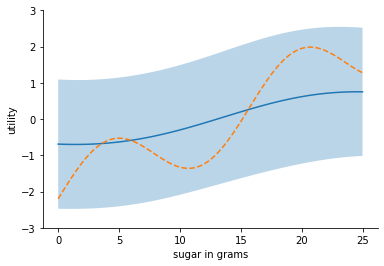

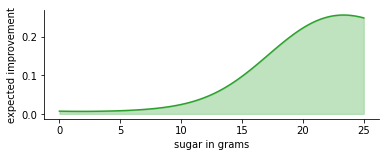

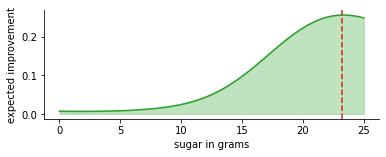

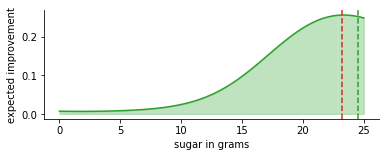

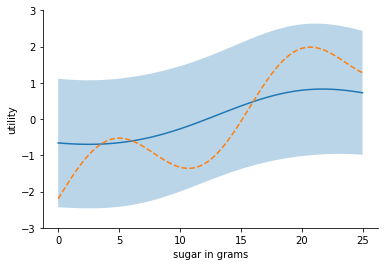

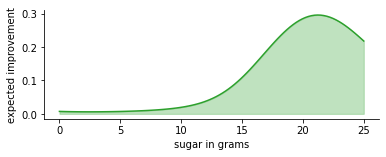

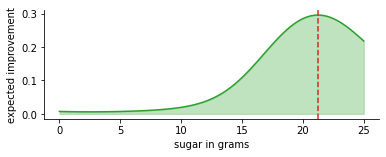

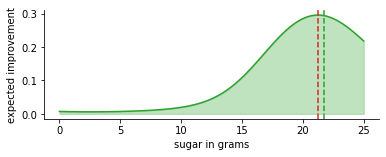

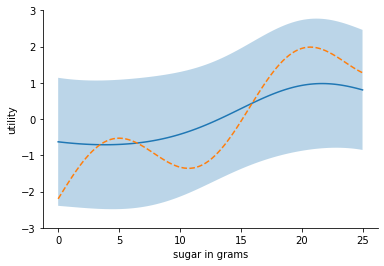

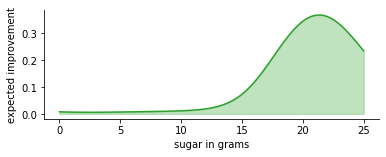

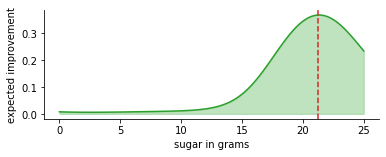

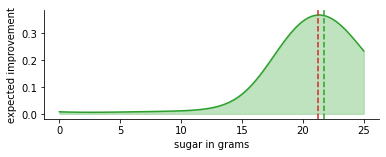

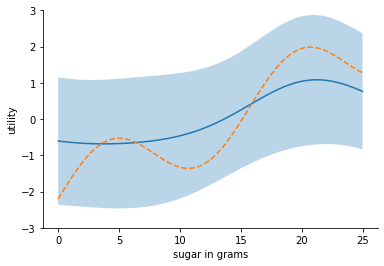

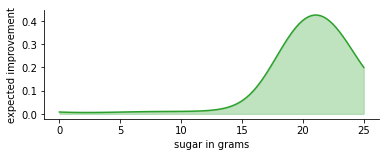

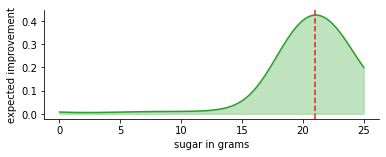

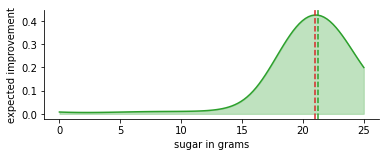

In [14]:
bounds = torch.stack([torch.zeros(1), 25 * torch.ones(1)])

ei = IncumbentExpectedImprovement(bounds, n_restarts=10, n_raw_samples=10)
covar_module = gpytorch.kernels.RBFKernel(
    lengthscale_constraint=gpytorch.constraints.GreaterThan(2.5)
)

single_experiment(
    f,
    1,
    torch.tensor([20]).float(),
    bounds,
    ei,
    covar_module=covar_module,
    noise=0,
    budget=10,
    visualize_fn=visualize_belief_and_ei,
    seed=6,  # 1, 40
);

# repeated experiments

In [1]:
import numpy as np

np.random.seed(0)

import torch

torch.manual_seed(0)

import sys

sys.path.append("../")

from optimization.experiments import repeated_experiments
from benchmarks.d1 import get_benchmark_1d
from benchmarks.d2 import get_benchmark_2d
from benchmarks.d3 import get_benchmark_3d
from optimization.opt_utils import plot_gaps

from policies.random import RandomPolicy
from policies.regular_bo import ExpectedImprovement
from policies.incumbent import IncumbentExpectedImprovement

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["font.family"] = "sans-serif"

In [2]:
n_trials = 10
noise = 1e-6

acq_funcs = [RandomPolicy, ExpectedImprovement, IncumbentExpectedImprovement]
# acq_fn_names = [acq_fn.__name__ for acq_fn in acq_funcs]
acq_fn_names = ["random", "EI2", "EI-incumbent"]

## 1d

In [3]:
dim = 1
budget = 10

names = ["f1", "f3"]

fs = []
bounds = []
xs_opt = []

for name in names:
    f, tmp_bounds, x_opt = get_benchmark_1d(name)
    fs.append(f)
    bounds.append(tmp_bounds)
    xs_opt.append(x_opt)

In [4]:
gaps = repeated_experiments(
    fs,
    xs_opt,
    bounds,
    dim,
    acq_funcs,
    n_trials=n_trials,
    noise=noise,
    budget=budget,
    verbose=True,
)

Function f1
	Acq. RandomPolicy
		 0 1 2 3 4 5 6 7 8 9 
	Acq. ExpectedImprovement
		 0 1 2 3 4 5 6 7 8 9 
	Acq. IncumbentExpectedImprovement
		 0 1 2 3 4 5 6 7 8 9 
Function f3
	Acq. RandomPolicy
		 0 1 2 3 4 5 6 7 8 9 
	Acq. ExpectedImprovement
		 0 1 2 3 4 5 6 7 8 9 
	Acq. IncumbentExpectedImprovement
		 0 1 2 3 4 5 6 7 8 9 


In [5]:
torch.save(gaps, "gaps_1d.pt")

In [4]:
gaps = torch.load("gaps_1d.pt")

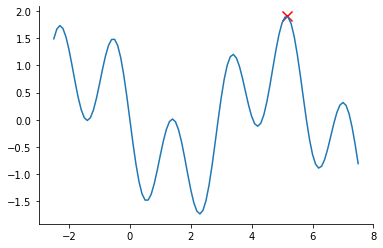

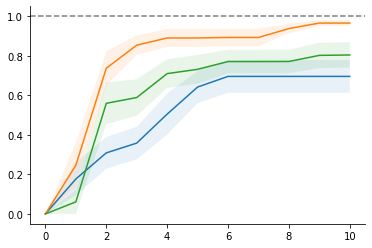

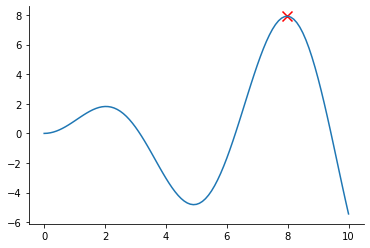

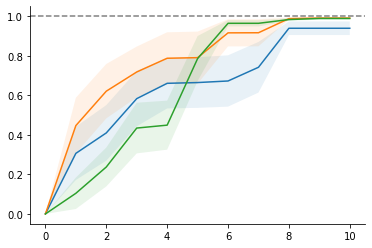

In [5]:
for f_ind, name in enumerate(names):
    f, tmp_bounds, x_opt = get_benchmark_1d(name)
    x_test = torch.linspace(tmp_bounds[0, 0], tmp_bounds[1, 0], 101)
    plt.plot(x_test, f(x_test))
    plt.scatter(x_opt, f(x_opt), c="r", marker="x", s=100)
    plt.show()

    plot_gaps(gaps[f_ind], acq_fn_names)
    plt.show()

In [9]:
gaps.mean(axis=2)[..., -1]

tensor([[0.6957, 0.9655, 0.8041],
        [0.9392, 0.9907, 0.9888]])

## 2d

In [21]:
dim = 2
budget = 30

names = [
    "three-hump camel",
    "griewank",
]

fs = []
bounds = []
xs_opt = []

for name in names:
    f, tmp_bounds, x_opt = get_benchmark_2d(name)
    fs.append(f)
    bounds.append(tmp_bounds)
    xs_opt.append(x_opt)

In [4]:
gaps = repeated_experiments(
    fs,
    xs_opt,
    bounds,
    dim,
    acq_funcs,
    n_trials=n_trials,
    noise=noise,
    budget=budget,
    verbose=True,
)

Function three_hump_camel
	Acq. RandomPolicy
		 0 1 2 3 4 5 6 7 8 9 
	Acq. ExpectedImprovement
		 0 1 2 3 4 5 6 7 8 9 
	Acq. IncumbentExpectedImprovement
		 0 1 2 3 4 5 6 7 8 9 
Function griewank
	Acq. RandomPolicy
		 0 1 2 3 4 5 6 7 8 9 
	Acq. ExpectedImprovement
		 0 1 2 3 4 5 6 7 8 9 
	Acq. IncumbentExpectedImprovement
		 0 1 2 3 4 5 6 7 8 9 


In [5]:
torch.save(gaps, "gaps_2d.pt")

In [22]:
gaps = torch.load("gaps_2d.pt")

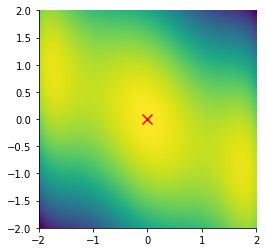

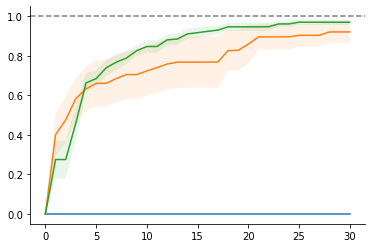

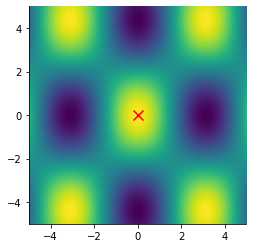

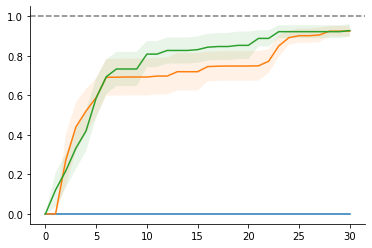

In [24]:
for f_ind, name in enumerate(names):
    f, tmp_bounds, x_opt = get_benchmark_2d(name)
    x1_test = torch.linspace(tmp_bounds[0, 0], tmp_bounds[1, 0], 101)
    x2_test = torch.linspace(tmp_bounds[0, 1], tmp_bounds[1, 1], 101)
    x_test = torch.hstack(
        [x.reshape(-1, 1) for x in list(torch.meshgrid(x1_test, x2_test))]
    )

    plt.imshow(
        f(x_test).reshape(101, 101).T,
        origin="lower",
        extent=[tmp_bounds[0, 0], tmp_bounds[1, 0], tmp_bounds[0, 1], tmp_bounds[1, 1]],
    )
    plt.scatter(x_opt[0], x_opt[1], c="r", marker="x", s=100)
    plt.show()

    plot_gaps(gaps[f_ind], acq_fn_names)
    plt.show()

In [8]:
gaps.mean(axis=2)[..., -1]

tensor([[0.0000, 0.9207, 0.9699],
        [0.0000, 0.9245, 0.9275]])

## 3d

In [3]:
dim = 3
budget = 50

names = [
    "rosenbrock",
    "griewank",
]

fs = []
bounds = []
xs_opt = []

for name in names:
    f, tmp_bounds, x_opt = get_benchmark_3d(name)
    fs.append(f)
    bounds.append(tmp_bounds)
    xs_opt.append(x_opt)

In [4]:
gaps = repeated_experiments(
    fs,
    xs_opt,
    bounds,
    dim,
    acq_funcs,
    n_trials=n_trials,
    noise=noise,
    budget=budget,
    verbose=True,
)

Function rosenbrock
	Acq. RandomPolicy
		 0 1 2 3 4 5 6 7 8 9 
	Acq. ExpectedImprovement
		 0 1 2 3 4 5 6 7 8 9 
	Acq. IncumbentExpectedImprovement
		 0 1 2 3 4 5 6 7 8 9 
Function griewank
	Acq. RandomPolicy
		 0 1 2 3 4 5 6 7 8 9 
	Acq. ExpectedImprovement
		 0 1 2 3 4 5 6 7 8 9 
	Acq. IncumbentExpectedImprovement
		 0 1 2 3 4 5 6 7 8 9 


In [5]:
torch.save(gaps, "gaps_3d.pt")

In [4]:
gaps = torch.load("gaps_3d.pt")

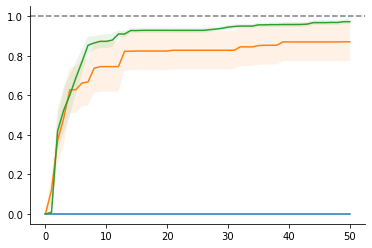

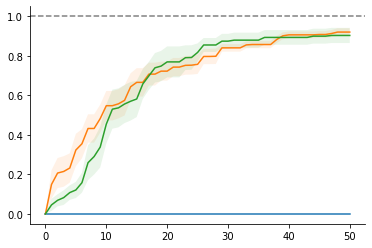

In [6]:
for f_ind, name in enumerate(names):
    plot_gaps(gaps[f_ind], acq_fn_names)
    plt.show()

In [7]:
gaps.mean(axis=2)[..., -1]

tensor([[0.0000, 0.8706, 0.9725],
        [0.0000, 0.9199, 0.9028]])